In [1]:
import os
import sys
import json
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
from pprint import pprint
from IPython.display import display
from functools import reduce
import pandas as pd
import pathlib
from sklearn.metrics import classification_report
import numpy as np
import json
from pprint import pprint

current_path = os.path.dirname(os.path.abspath("./"))
print(current_path)
sys.path.append(current_path)

# Local helper modules
import helper
from helper import read_json, matchMLKeyWords
import commonpath
from commonpath import FIG_DIR, OUTPUT_DIR, PROJ_REPOS_CHUNKS_QA_DIR, PROJ_REPOS_PATH
from collections import defaultdict

# !pip install rapidfuzz
# !pip install tldextract
import tldextract
from rapidfuzz import fuzz, utils
import pickle

/home/jupyter-lihao/mlbindings/src
import facets_overview error!


In [2]:
def formatPlatform(df):
    df["Platform"] = df["Platform"].apply(lambda x: helper.PLATFORM_NAME_FOR_SHOWN[x] if x in helper.PLATFORM_NAME_FOR_SHOWN else x)

# Load data

In [3]:
rq2_ml_bindings = pd.read_csv(commonpath.DATA_DIR / "rq2_ml_bindings.csv")
rq2_ml_bindings = helper.formatIDColumnsToStr(rq2_ml_bindings)
rq2_ml_bindings["Host Repo IDs"] = rq2_ml_bindings["Host Repo IDs"].apply(lambda x: eval(x))

rq2_ml_repos = pd.read_csv(commonpath.DATA_DIR / "rq2_ml_repos.csv")
rq2_ml_repos = helper.formatIDColumnsToStr(rq2_ml_repos)

rq2_packages = pd.read_csv(commonpath.DATA_DIR / "rq2_packages.csv")
rq2_packages = helper.formatIDColumnsToStr(rq2_packages)
rq2_packages["Host Repo IDs"] = rq2_packages["Host Repo IDs"].apply(helper.formatIDToStr)

In [4]:
binding_projects = pd.read_csv(commonpath.DATA_DIR / "all_bindings.csv")
binding_projects = helper.formatIDColumnsToStr(binding_projects)
binding_projects

/tmp/ipykernel_363997/1526741578.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  binding_projects = pd.read_csv(commonpath.DATA_DIR / "all_bindings.csv")


,Unnamed: 0,ID,Platform,Name,Description,Keywords,Licenses,Repository URL,Versions Count,Dependent Projects Count,...,Repository Host Type,Repository Name with Owner,Repository Description,Repository Fork?,Repository Stars Count,Repository License,Repository Status,Repository Keywords,Binding Host,Homepage URL
0,0,29195,Pub,FileTeCouch,"A Couchbase Server client library, based on Co...",NaN,Apache-2.0,https://github.com/Kordam/FileTeCouch,13,0,...,GitHub,Kordam/FileTeCouch,"Librarie based on CouchClient, the Rikulo Couc...",False,2.0,Apache-2.0,NaN,NaN,Couchbase Server,https://github.com/Kordam/FileTeCouch/
1,1,29202,Pub,ace,Dart bindings for the Ace code editor.,NaN,MIT,https://github.com/DirectMyFile/ace.dart,46,1,...,GitHub,rmsmith/ace.dart,NaN,False,22.0,MIT,Removed,NaN,Ace,https://github.com/DirectMyFile/ace.dart/
2,2,29209,Pub,add_v1_api,Auto-generated client library for accessing th...,NaN,BSD-3-Clause,https://github.com/dart-gde/discovery_api_dart...,1,0,...,GitHub,dart-lang/discoveryapis_generator,Create API Client libraries based on the API's...,False,70.0,BSD-3-Clause,NaN,NaN,add v1,https://github.com/dart-gde/discovery_api_dart...
3,3,29214,Pub,aloha,Bindings for the Aloha HTML5 editor. Allows te...,NaN,GPL-3.0,https://github.com/shamblett/aloha,5,0,...,GitHub,shamblett/aloha,Aloha HTML editor bindings,False,2.0,GPL-3.0,NaN,dart,Aloha HTML5,https://github.com/shamblett/aloha/
4,4,29216,Pub,amazon_s3,Amazon S3 API,NaN,NaN,NaN,11,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Amazon S3,http://vacuumlabs.com/
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250663,250663,4793629,Rubygems,tauron,TauronAPI Client Library.,NaN,NaN,NaN,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TauronAPI,https://github.azc.ext.hp.com/3DSoftware/ruby-...
250664,250664,4793638,Pypi,speak2mary,A Python wrapper for Mary TTS,NaN,Apache-2.0,https://github.com/Poeschl/speak2mary,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mary TTS,https://github.com/Poeschl/speak2mary/
250665,250665,4793645,Packagist,ajardin/origami,A PHP toolbox to manage local Docker environme...,NaN,MIT,https://github.com/ajardin/origami,0,0,...,GitHub,ajardin/origami-source,:whale: :rocket: A PHP toolbox to manage local...,False,0.0,MIT,NaN,NaN,Docker,NaN
250666,250666,4793652,NPM,react-native-line-private,React Native Line wrapper,NaN,MIT,https://github.com/xmartlabs/react-native-line,1,0,...,GitHub,xmartlabs/react-native-line,NaN,False,43.0,MIT,NaN,NaN,Native Line,https://github.com/xmartlabs/react-native-line/


In [5]:
from urllib.parse import urlparse, urlunparse, parse_qs, urlencode

def normalize_url(url):
    if not isinstance(url, str):
        return np.nan
    # Parse the URL
    parsed_url = urlparse(url)
    
    # Normalize the scheme and netloc
    scheme = parsed_url.scheme.lower()
    netloc = parsed_url.netloc.lower()
    
    # Strip 'www.'
    if netloc.startswith("www."):
        netloc = netloc[4:]
        
    # Add or remove default ports
    if scheme == "http" and ":80" in netloc:
        netloc = netloc.replace(":80", "")
    elif scheme == "https" and ":443" in netloc:
        netloc = netloc.replace(":443", "")
    
    # Normalize the path
    path = parsed_url.path
    if not path.endswith("/"):
        path += "/"
    
    # Sort query parameters
    query = urlencode(sorted(parse_qs(parsed_url.query, keep_blank_values=True).items()), doseq=True)
    
    # Reassemble the URL (excluding fragment)
    normalized_url = urlunparse((scheme, netloc, path, '', query, ''))
    
    return normalized_url

# Num of Ecosystems

In [6]:
def plotGroupPlatform(group):
    fig1, ax1 = plt.subplots(figsize=(12, 3))
    host_rid_cross_g = group[host_rid_g>0]
    vp = ax1.violinplot(
        host_rid_cross_g, vert=False, showmedians=True,
        showextrema=False, showmeans=False
    )

    # Customizing the violin plot
    for body in vp['bodies']:
        body.set_facecolor('grey')  # Set the violin plot area to grey
        body.set_edgecolor('black')
        body.set_alpha(0.7)

    # Customizing the median line
    # Since violinplot doesn't accept medianprops, we manually adjust the median line.
    # vp['cmedians'] is a LineCollection; we adjust its linewidth and color.
    vp['cmedians'].set_edgecolor('black')
    vp['cmedians'].set_linewidth(3)

    # Adjusting labels and ticks for readability
    ax1.set_xlabel("Number of ecosystems", fontsize=16)
    ax1.xaxis.set_tick_params(labelsize=13)
    ax1.yaxis.set_tick_params(labelsize=13)
    plt.xticks(list(range(1, host_rid_cross_g.max() + 1)), list(range(1, host_rid_cross_g.max() + 1)))
    # ax1.set(ylim=(1, 1.3))
    plt.yticks([], [])  # Continue to hide y-ticks as before

    plt.show()
    return fig1

/tmp/ipykernel_363997/912063093.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  host_rid_g = ml_bindings_and_projects.groupby("Host Repo IDs").apply(lambda x: len(x["Platform"].unique()))


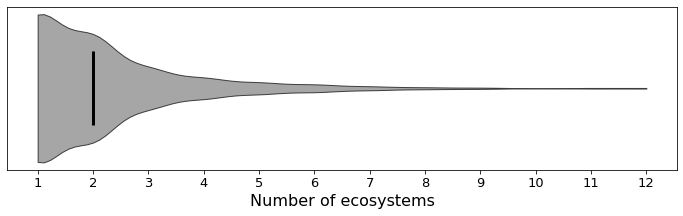

244 / 546 = 44.68864468864469% 1
166 / 546 = 30.4029304029304% 2
61 / 546 = 11.172161172161173% 3
32 / 546 = 5.86080586080586% 4
18 / 546 = 3.296703296703297% 5
12 / 546 = 2.197802197802198% 6
6 / 546 = 1.098901098901099% 7
3 / 546 = 0.5494505494505495% 8
2 / 546 = 0.3663003663003663% 9
1 / 546 = 0.18315018315018314% 11
1 / 546 = 0.18315018315018314% 12
Host Repo IDs
18883757     6
845081       6
3727191      7
38193711     7
14048954     7
22309865     7
32528693     7
186909       7
852009       8
37860773     8
573443       8
339654       9
38722051     9
3109714     11
851991      12
dtype: int64


In [7]:
ml_bindings_and_projects = rq2_packages
host_rid_g = ml_bindings_and_projects.groupby("Host Repo IDs").apply(lambda x: len(x["Platform"].unique()))
fig = plotGroupPlatform(host_rid_g)
helper.printValueCountsPercentage(host_rid_g)
helper.savefig(fig, "RQ2_Num_Ecosystems")
print(host_rid_g.sort_values().tail(15))

# Distrubition in ecosystems

In [8]:
# print(sum(ml_bindings_and_projects["Type"] == "Project"))
def plotPlatforms(projs_df, groupby="Host Repo IDs", title=""):
    popular_ml_packs_platforms = pd.DataFrame(
        projs_df
            .groupby(groupby)
            .apply(lambda df: df["Platform"].unique())
        , columns=["Platforms"]
    ).reset_index()
    repo_platforms = {
        "Host Repo IDs": [],
        "Platform": [],
    }
    for rid, platforms in zip(popular_ml_packs_platforms["Host Repo IDs"], popular_ml_packs_platforms["Platforms"]):
        repo_platforms["Host Repo IDs"].extend([rid] * len(platforms))
        repo_platforms["Platform"].extend(platforms)
    repo_platforms = pd.DataFrame(repo_platforms)
    figure, ax = plt.subplots()
    figure.set_size_inches(helper.FIG_SIZE_WIDE)
    repo_platforms_counts = repo_platforms["Platform"].value_counts()
    print(repo_platforms_counts)
    print(f"divided by {len(popular_ml_packs_platforms)}")
    print(repo_platforms_counts / len(popular_ml_packs_platforms) * 100)
    
    for eco in helper.PICKUP_PLATFORMS_FOR_SHOWN:
        if eco in repo_platforms_counts.index:
            # print(f"{eco}: {repo_platforms_counts[eco]} / {len(popular_ml_packs_platforms)} = {repo_platforms_counts[eco] / len(popular_ml_packs_platforms) * 100}")
            continue
        repo_platforms_counts._set_value(eco, 0)
        # print(f"{eco}: {repo_platforms_counts[eco]} / {len(popular_ml_packs_platforms)} = 0")
    show_figure_rq1 = repo_platforms_counts.sort_values(ascending=False)
    # for eco, num in zip(show_figure_rq1.index, show_figure_rq1.values):
    #     helper.printPercentage(num, len(popular_ml_libs), eco)
    # print(show_figure_rq1)
    # print(sum(show_figure_rq1.values[:-1]))
    # helper.printPercentage(sum(show_figure_rq1.values[-4:]), sum(show_figure_rq1.values), "Top 4 ecosystems")
    # show_figure_rq1.index = [a if a not in platform_name_for_shown else platform_name_for_shown[a] for a in show_figure_rq1.index]
    ax.bar(range(len(show_figure_rq1.index)), show_figure_rq1.values, width=0.7, color='dimgray')
    # ax.bar(range(len(show_figure_rq1.index)), show_figure_rq1.values, width=0.7, color="k")
    plt.xticks(list(range(len(show_figure_rq1.index))), list(show_figure_rq1.index), fontsize=15, rotation=30)
    plt.yticks(fontsize=15)
    # plt.yticks([0, 1000, 2000, 3000, 4000], ["0", "1,000", "2,000", "3,000", "4,000"], fontsize=14)
    ax.set_ylabel("Number of ML libraries with bindings", fontsize=18)
    ax.set_xlabel("Ecosystem", fontsize=18)
    ax.set_title(title)
    plt.show()
    return figure

## Official packages and bindings

2765 / 3540 = 78.10734463276836% Binding
775 / 3540 = 21.89265536723164% Project

ML libraries that have official *main* packages
344 / 546 = 63.003663003663% False
202 / 546 = 36.996336996337% True

ML libraries that have official packages
310 / 546 = 56.776556776556774% False
236 / 546 = 43.223443223443226% True

is official:
2557 / 3540 = 72.23163841807909% community
494 / 3540 = 13.954802259887005% linked same_repo
281 / 3540 = 7.937853107344633% linked same_repo_url
114 / 3540 = 3.2203389830508473% same_repo
85 / 3540 = 2.401129943502825% same_repo_owner
9 / 3540 = 0.2542372881355932% same_repo_url_owner

Official organization mainly targeting one ecosystem
205 / 236 = 86.86440677966102% 1
21 / 236 = 8.898305084745763% 2
8 / 236 = 3.389830508474576% 3
1 / 236 = 0.423728813559322% 7
1 / 236 = 0.423728813559322% 5

type:
775 / 983 = 78.84028484231943% Project
208 / 983 = 21.15971515768057% Binding
Platform
PyPI         163
npm           30
Maven         20
NuGet         17
CRAN     

/tmp/ipykernel_363997/3024503232.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  found_main_package = rq2_packages.groupby("Host Repo IDs").apply(lambda x: any(x["Type"] == "Project"))
/tmp/ipykernel_363997/3024503232.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  found_package = rq2_packages.groupby("Host Repo IDs").apply(lambda x: any(x["is official"] != "community"))
/tmp/ipykernel_363997/302450

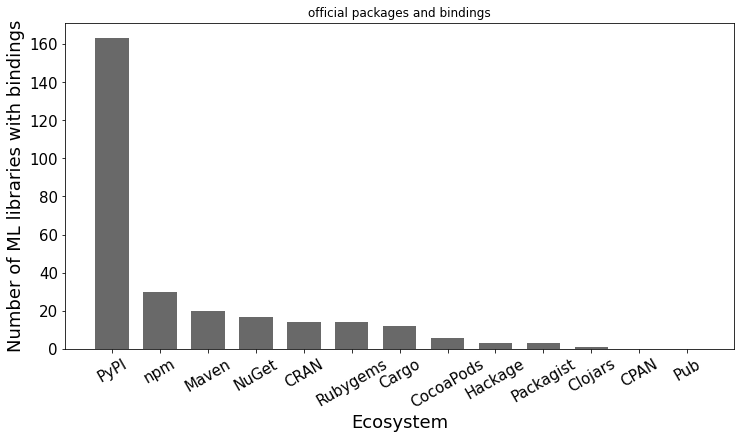

In [9]:
helper.printValueCountsPercentage(rq2_packages["Type"])
found_main_package = rq2_packages.groupby("Host Repo IDs").apply(lambda x: any(x["Type"] == "Project"))
print("\nML libraries that have official *main* packages")
helper.printValueCountsPercentage(found_main_package)
found_package = rq2_packages.groupby("Host Repo IDs").apply(lambda x: any(x["is official"] != "community"))
print("\nML libraries that have official packages")
helper.printValueCountsPercentage(found_package)

print("\nis official:")
helper.printValueCountsPercentage(ml_bindings_and_projects["is official"])
official_packages = ml_bindings_and_projects[ml_bindings_and_projects["is official"] != "community"]

print("\nOfficial organization mainly targeting one ecosystem")
host_rid_g = official_packages.groupby("Host Repo IDs").apply(lambda x: len(x["Platform"].unique()))
helper.printValueCountsPercentage(host_rid_g)

print("\ntype:")
helper.printValueCountsPercentage(official_packages["Type"])

fig = plotPlatforms(official_packages, title="official packages and bindings")
# fig = plotPlatforms(official_packages[official_packages["Type"] != "Binding"], title="official packages")
# fig = plotPlatforms(official_packages[official_packages["Type"] == "Binding"], title="official bindings")

## All bindings

Platform
npm          292
PyPI         225
Rubygems      95
NuGet         92
Packagist     90
Maven         72
Cargo         43
CocoaPods     37
Clojars       31
CRAN          24
CPAN          16
Hackage       12
Pub            6
Name: count, dtype: int64
divided by 546
Platform
npm          53.479853
PyPI         41.208791
Rubygems     17.399267
NuGet        16.849817
Packagist    16.483516
Maven        13.186813
Cargo         7.875458
CocoaPods     6.776557
Clojars       5.677656
CRAN          4.395604
CPAN          2.930403
Hackage       2.197802
Pub           1.098901
Name: count, dtype: float64


/tmp/ipykernel_363997/3455684477.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  projs_df


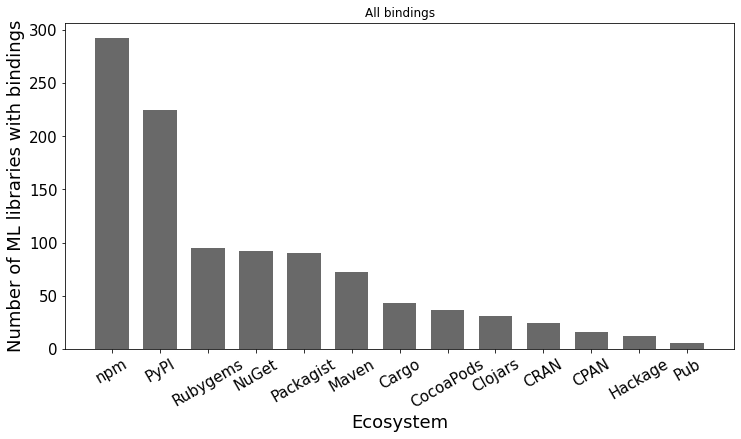

---------- PyPI ----------
321 / 546 = 58.791208791208796% not found
173 / 546 = 31.684981684981683% False
52 / 546 = 9.523809523809524% True
---------- Packagist ----------
456 / 546 = 83.51648351648352% not found
88 / 546 = 16.117216117216117% False
2 / 546 = 0.3663003663003663% True
---------- Rubygems ----------


/tmp/ipykernel_363997/3181741109.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  eco_has_offcial = all_bindings.groupby("Host Repo IDs").apply(lambda x: hasOfficial(x, eco))
/tmp/ipykernel_363997/3181741109.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  eco_has_offcial = all_bindings.groupby("Host Repo IDs").apply(lambda x: hasOfficial(x, eco))
/tmp/ipykernel_363997/3181741109.py:11: DeprecationW

451 / 546 = 82.6007326007326% not found
86 / 546 = 15.75091575091575% False
9 / 546 = 1.6483516483516485% True
---------- Hackage ----------
534 / 546 = 97.8021978021978% not found
10 / 546 = 1.8315018315018317% False
2 / 546 = 0.3663003663003663% True
---------- Cargo ----------
503 / 546 = 92.12454212454212% not found
39 / 546 = 7.142857142857142% False
4 / 546 = 0.7326007326007326% True
---------- npm ----------


/tmp/ipykernel_363997/3181741109.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  eco_has_offcial = all_bindings.groupby("Host Repo IDs").apply(lambda x: hasOfficial(x, eco))
/tmp/ipykernel_363997/3181741109.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  eco_has_offcial = all_bindings.groupby("Host Repo IDs").apply(lambda x: hasOfficial(x, eco))


284 / 546 = 52.01465201465202% False
254 / 546 = 46.52014652014652% not found
8 / 546 = 1.465201465201465% True
---------- Maven ----------
474 / 546 = 86.81318681318682% not found
62 / 546 = 11.355311355311356% False
10 / 546 = 1.8315018315018317% True
---------- NuGet ----------
454 / 546 = 83.15018315018315% not found
84 / 546 = 15.384615384615385% False
8 / 546 = 1.465201465201465% True
---------- CPAN ----------


/tmp/ipykernel_363997/3181741109.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  eco_has_offcial = all_bindings.groupby("Host Repo IDs").apply(lambda x: hasOfficial(x, eco))
/tmp/ipykernel_363997/3181741109.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  eco_has_offcial = all_bindings.groupby("Host Repo IDs").apply(lambda x: hasOfficial(x, eco))
/tmp/ipykernel_363997/3181741109.py:11: DeprecationW

530 / 546 = 97.06959706959707% not found
16 / 546 = 2.93040293040293% False
---------- CRAN ----------
522 / 546 = 95.6043956043956% not found
19 / 546 = 3.47985347985348% False
5 / 546 = 0.9157509157509158% True
---------- Pub ----------
540 / 546 = 98.9010989010989% not found
6 / 546 = 1.098901098901099% False
---------- Clojars ----------
515 / 546 = 94.32234432234432% not found
30 / 546 = 5.4945054945054945% False
1 / 546 = 0.18315018315018314% True
---------- CocoaPods ----------
509 / 546 = 93.22344322344323% not found
35 / 546 = 6.41025641025641% False
2 / 546 = 0.3663003663003663% True


/tmp/ipykernel_363997/3181741109.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  eco_has_offcial = all_bindings.groupby("Host Repo IDs").apply(lambda x: hasOfficial(x, eco))
/tmp/ipykernel_363997/3181741109.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  eco_has_offcial = all_bindings.groupby("Host Repo IDs").apply(lambda x: hasOfficial(x, eco))
/tmp/ipykernel_363997/3181741109.py:11: DeprecationW

In [10]:
all_bindings = rq2_packages[rq2_packages["Type"] == "Binding"]
figure = plotPlatforms(all_bindings, title="All bindings")
def hasOfficial(df, dstPlatform):
    mask = df["Platform"] == dstPlatform
    if sum(mask) == 0:
        return "not found"
    return any(df[mask]["is official"] != "community")

for eco in ml_bindings_and_projects["Platform"].unique():
    print("-" * 10, eco, "-" * 10)
    eco_has_offcial = all_bindings.groupby("Host Repo IDs").apply(lambda x: hasOfficial(x, eco))
    helper.printValueCountsPercentage(eco_has_offcial)

938 / 1156 = 81.14186851211073% False
218 / 1156 = 18.858131487889274% True
2127 / 3540 = 60.08474576271187% True
1413 / 3540 = 39.91525423728813% False
Platform
PyPI         154
npm          120
NuGet         44
Maven         41
Rubygems      39
Packagist     27
Cargo         26
CRAN          25
Clojars       17
CocoaPods     17
Hackage        7
Name: count, dtype: int64
divided by 202
Platform
PyPI         76.237624
npm          59.405941
NuGet        21.782178
Maven        20.297030
Rubygems     19.306931
Packagist    13.366337
Cargo        12.871287
CRAN         12.376238
Clojars       8.415842
CocoaPods     8.415842
Hackage       3.465347
Name: count, dtype: float64


/tmp/ipykernel_363997/3241313030.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  has_official_projects = rq2_packages.groupby(["Host Repo IDs", "Platform"]).apply(lambda x: any(x["Type"] == "Project")).reset_index()
/tmp/ipykernel_363997/3455684477.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  projs_df


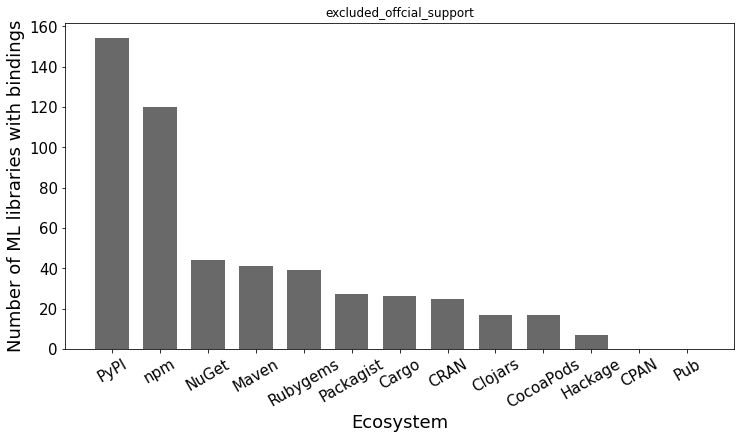

In [11]:
has_official_projects = rq2_packages.groupby(["Host Repo IDs", "Platform"]).apply(lambda x: any(x["Type"] == "Project")).reset_index()
helper.printValueCountsPercentage(has_official_projects[0])
has_official_projects_rids_p = has_official_projects[has_official_projects[0]]

excluded_mask = np.logical_and(rq2_packages["Host Repo IDs"].isin(has_official_projects_rids_p["Host Repo IDs"]), rq2_packages["Platform"].isin(has_official_projects_rids_p["Platform"]))
helper.printValueCountsPercentage(excluded_mask)

excluded_offcial_support = rq2_packages[excluded_mask]
figure = plotPlatforms(excluded_offcial_support, title="excluded_offcial_support")
# has_official_bindings = rq2_packages.groupby(["Host Repo IDs", "Platform"]).apply(lambda x: any(x["is official"] == "community")).reset_index()
# helper.printValueCountsPercentage(has_official_bindings[0])
# has_official_bindings

# ML libraries that found in multiple ecosystems

In [12]:
host_rid_g = ml_bindings_and_projects.groupby("Host Repo IDs").apply(lambda x: len(x["Platform"].unique()))
cross_eco_ml_rids = host_rid_g[host_rid_g>1].index
helper.printValueCountsPercentage(host_rid_g)
cross_eco_ml_packages = ml_bindings_and_projects[ml_bindings_and_projects["Host Repo IDs"].isin(cross_eco_ml_rids)]
cross_eco_ml_packages

244 / 546 = 44.68864468864469% 1
166 / 546 = 30.4029304029304% 2
61 / 546 = 11.172161172161173% 3
32 / 546 = 5.86080586080586% 4
18 / 546 = 3.296703296703297% 5
12 / 546 = 2.197802197802198% 6
6 / 546 = 1.098901098901099% 7
3 / 546 = 0.5494505494505495% 8
2 / 546 = 0.3663003663003663% 9
1 / 546 = 0.18315018315018314% 11
1 / 546 = 0.18315018315018314% 12


/tmp/ipykernel_363997/2815410471.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  host_rid_g = ml_bindings_and_projects.groupby("Host Repo IDs").apply(lambda x: len(x["Platform"].unique()))


,ID,Platform,Name,Description,Keywords,Licenses,Repository URL,Versions Count,Dependent Projects Count,Status,...,Binding Host,Homepage URL,Homepage Domain,Binding Host Normalized,Binding Host Normalized - No Space,Host Repo IDs,is official,Type,Repository Homepage URL,Repository Homepage Domain
0,31970,PyPI,AlchemyAPI,Python access to AlchemyAPI for unstructured t...,alchemyapi api semantic nlp,BSD-3-Clause,NaN,0,0,NaN,...,Alchemy,http://www.alchemyapi.com/,alchemyapi,alchemy,alchemy,40396672,community,Binding,NaN,NaN
1,32402,PyPI,ArenaPy,A simple python interface to the Are.na api,arena rest api client,MIT,https://github.com/jnhasty/arenapy,1,0,NaN,...,Are.na,https://github.com/jnhasty/arenapy,github,are na,arena,37026823,community,Binding,NaN,NaN
3,36041,PyPI,CVtypes,Python OpenCV wrapper using ctypes,OpenCV ctypes wxPython,AFL-3.0,NaN,0,0,NaN,...,OpenCV,http://wwwx.cs.unc.edu/~gb/wp/blog/2007/02/04/...,unc,opencv,opencv,851991,community,Binding,NaN,NaN
4,44874,PyPI,enet,Enet library bindings for Python.,NaN,Other,NaN,0,0,NaN,...,Enet,UNKNOWN,UNKNOWN,enet,enet,24799903,community,Binding,NaN,NaN
5,52201,PyPI,ikedarts,Python interface to DARTS by Kudo Taku.,NaN,Other,https://github.com/tengu/ikedarts,3,0,NaN,...,DARTS,https://github.com/tengu/ikedarts,github,darts,darts,36863929,community,Binding,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3535,4698471,PyPI,tensorflow-cpu-estimator,TensorFlow Estimator.,tensorflow estimator tensor machine learning,Apache-2.0,NaN,1,0,NaN,...,NaN,https://tensorflow.org/,tensorflow,NaN,NaN,3109714,linked same_repo_url,Project,NaN,NaN
3536,4766445,PyPI,tensorflow-gpu-estimator,TensorFlow Estimator (GPU).,tensorflow estimator tensor machine learning,Apache-2.0,NaN,1,0,NaN,...,NaN,https://tensorflow.org/,tensorflow,NaN,NaN,3109714,linked same_repo_url,Project,NaN,NaN
3537,4766669,NuGet,Microsoft.ML.Featurizers,ML.NET featurizers with native code implementa...,"ML,ML.NET,Machine,Learning",NaN,NaN,1,0,NaN,...,NaN,https://dot.net/ml/,dot,NaN,NaN,35948367,linked same_repo_url,Project,NaN,NaN
3538,4778451,NuGet,glgoo.opencv,The nuget package of OpenCV4.2.0 is comprised ...,"nativepackage,v140,x64,v150,CoApp,opencv",NaN,NaN,2,0,NaN,...,NaN,https://opencv.org/,opencv,NaN,NaN,851991,linked same_repo_url,Project,NaN,NaN


## Distribution of ecosystems of bindings for cross-ecosystem ML libraries

/tmp/ipykernel_363997/3455684477.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  projs_df


Platform
npm          213
PyPI         134
Packagist     77
Rubygems      77
NuGet         74
Maven         64
Cargo         38
CocoaPods     32
Clojars       27
CRAN          24
CPAN          14
Hackage       11
Pub            6
Name: count, dtype: int64
divided by 302
Platform
npm          70.529801
PyPI         44.370861
Packagist    25.496689
Rubygems     25.496689
NuGet        24.503311
Maven        21.192053
Cargo        12.582781
CocoaPods    10.596026
Clojars       8.940397
CRAN          7.947020
CPAN          4.635762
Hackage       3.642384
Pub           1.986755
Name: count, dtype: float64


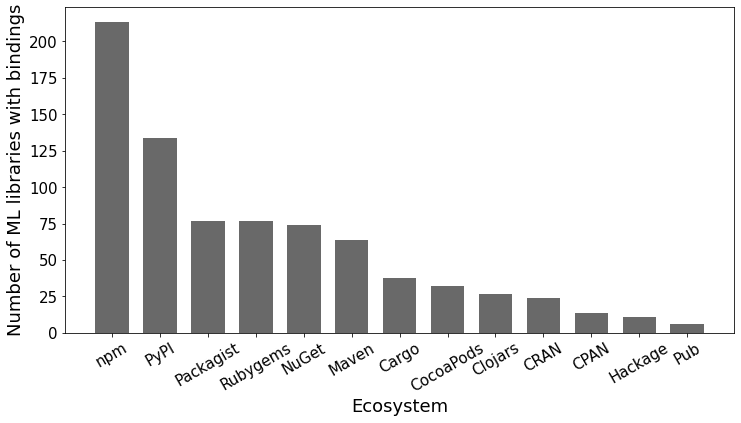

In [13]:
excluded_project = cross_eco_ml_packages[cross_eco_ml_packages["Type"] == "Binding"]
figure = plotPlatforms(excluded_project)
helper.savefig(figure, "RQ2_ML_Bindings_In_Ecos")

In [14]:
cross_eco_ml_packages

,ID,Platform,Name,Description,Keywords,Licenses,Repository URL,Versions Count,Dependent Projects Count,Status,...,Binding Host,Homepage URL,Homepage Domain,Binding Host Normalized,Binding Host Normalized - No Space,Host Repo IDs,is official,Type,Repository Homepage URL,Repository Homepage Domain
0,31970,PyPI,AlchemyAPI,Python access to AlchemyAPI for unstructured t...,alchemyapi api semantic nlp,BSD-3-Clause,NaN,0,0,NaN,...,Alchemy,http://www.alchemyapi.com/,alchemyapi,alchemy,alchemy,40396672,community,Binding,NaN,NaN
1,32402,PyPI,ArenaPy,A simple python interface to the Are.na api,arena rest api client,MIT,https://github.com/jnhasty/arenapy,1,0,NaN,...,Are.na,https://github.com/jnhasty/arenapy,github,are na,arena,37026823,community,Binding,NaN,NaN
3,36041,PyPI,CVtypes,Python OpenCV wrapper using ctypes,OpenCV ctypes wxPython,AFL-3.0,NaN,0,0,NaN,...,OpenCV,http://wwwx.cs.unc.edu/~gb/wp/blog/2007/02/04/...,unc,opencv,opencv,851991,community,Binding,NaN,NaN
4,44874,PyPI,enet,Enet library bindings for Python.,NaN,Other,NaN,0,0,NaN,...,Enet,UNKNOWN,UNKNOWN,enet,enet,24799903,community,Binding,NaN,NaN
5,52201,PyPI,ikedarts,Python interface to DARTS by Kudo Taku.,NaN,Other,https://github.com/tengu/ikedarts,3,0,NaN,...,DARTS,https://github.com/tengu/ikedarts,github,darts,darts,36863929,community,Binding,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3535,4698471,PyPI,tensorflow-cpu-estimator,TensorFlow Estimator.,tensorflow estimator tensor machine learning,Apache-2.0,NaN,1,0,NaN,...,NaN,https://tensorflow.org/,tensorflow,NaN,NaN,3109714,linked same_repo_url,Project,NaN,NaN
3536,4766445,PyPI,tensorflow-gpu-estimator,TensorFlow Estimator (GPU).,tensorflow estimator tensor machine learning,Apache-2.0,NaN,1,0,NaN,...,NaN,https://tensorflow.org/,tensorflow,NaN,NaN,3109714,linked same_repo_url,Project,NaN,NaN
3537,4766669,NuGet,Microsoft.ML.Featurizers,ML.NET featurizers with native code implementa...,"ML,ML.NET,Machine,Learning",NaN,NaN,1,0,NaN,...,NaN,https://dot.net/ml/,dot,NaN,NaN,35948367,linked same_repo_url,Project,NaN,NaN
3538,4778451,NuGet,glgoo.opencv,The nuget package of OpenCV4.2.0 is comprised ...,"nativepackage,v140,x64,v150,CoApp,opencv",NaN,NaN,2,0,NaN,...,NaN,https://opencv.org/,opencv,NaN,NaN,851991,linked same_repo_url,Project,NaN,NaN


In [15]:
len(cross_eco_ml_packages["Host Repo IDs"].unique())

302

['Cargo', 'Clojars', 'CocoaPods', 'CPAN', 'CRAN', 'Hackage', 'Maven', 'NPM', 'NuGet', 'Packagist', 'Pub', 'Pypi', 'Rubygems']


/home/jupyter-lihao/.local/lib/python3.9/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/jupyter-lihao/.local/lib/python3.9/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


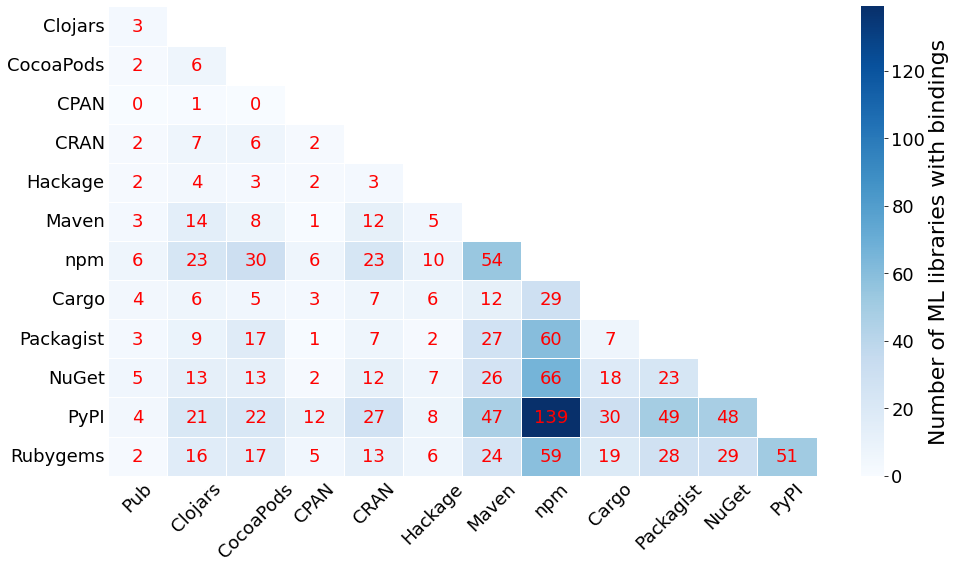

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

SORT_PLATFORMS = ['Pub', 'Clojars', 'CocoaPods', 'CPAN', 'CRAN', 'Hackage', 'Maven', 'npm', 'Cargo', 'Packagist', 'NuGet', 'PyPI', 'Rubygems']

print(helper.PICKUP_PLATFORMS)

graph_df = pd.DataFrame(0, index=SORT_PLATFORMS, columns=SORT_PLATFORMS)
lib_platforms_counter_df = {eco: 0 for eco in SORT_PLATFORMS}
for lib_name, ds in cross_eco_ml_packages.groupby("Host Repo IDs"):
    ecos = ds["Platform"].unique()
    for eco in ecos:
        lib_platforms_counter_df[eco] += 1
    
    for i in range(len(ecos) - 1):
        for j in range(i + 1, len(ecos)):
            graph_df.loc[ecos[i], ecos[j]] += 1
            graph_df.loc[ecos[j], ecos[i]] += 1

graph_df = graph_df.iloc[1:, :-1]
# display(graph_df)
# graph_df = graph_df.sort_values(by=graph_df.columns[0])
# row_sums = graph_df.sum(axis=1)
# row_sums.sort_values()
# graph_df["row_sum"] = row_sums
# graph_df = graph_df.sort_values('row_sum')

# display(graph_df)
# print(graph_df.index)
# graph_df = graph_df.drop('row_sum', axis=1)

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(14, 8))

# Choose a sequential colormap
cmap = sns.color_palette("Blues", as_cmap=True)
# cmap = sns.cubehelix_palette(light=1.0, as_cmap=True)
# cmap = sns.choose_diverging_palette(as_cmap=True)
# cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Optionally, remove diagonal for clarity
# np.fill_diagonal(graph_df.values, np.nan)

# Mask for the upper triangle
mask = np.triu(np.ones_like(graph_df, dtype=bool), k=1)

annot = True
number_size = 18
annot_kws={"size": number_size, "color": "red"}  # Adjust the size as needed

# Draw the heatmap with the mask
sns.heatmap(graph_df, mask=mask, cmap=cmap, annot=annot, annot_kws=annot_kws, fmt="d", linewidths=.5, ax=ax)

# Ensure the ticks are readable
# plt.xticks(rotation=45, ha='right', fontsize=12)
# plt.yticks(rotation=0, fontsize=12)

# Labels and title with improved font sizes
# plt.xlabel('Platforms', fontsize=16)
# plt.ylabel('Platforms', fontsize=16)
# plt.title('Cross-Ecosystem Packages in Machine Learning', fontsize=20)

# Adjust colorbar
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=number_size)
cbar.set_label("Number of ML libraries with bindings", fontsize=number_size + 4)

# Highlight the maximum value cells
highlight_max = np.max(graph_df.to_numpy().flatten())
sns.heatmap(graph_df, mask=graph_df <= highlight_max, cmap=cmap, annot=annot, annot_kws=annot_kws, fmt="d", cbar=False, ax=ax, linewidths=.5)
# sns.heatmap(graph_df, cmap=cmap, annot=True, fmt="d", cbar=False, ax=ax, linewidths=.5)
ax.tick_params(axis='both', which='both', length=0, labelsize=number_size)

plt.setp(ax.get_xticklabels(), rotation=45, ha="center", rotation_mode="default", va="top")

# Tight layout to fit everything
plt.tight_layout()

# Save the figure if needed
helper.savefig(fig, "RQ2_ML_Bindings_Pairs_Enhanced")

# Show the heatmap
plt.show()


In [17]:
rq2_ml_repos[rq2_ml_repos["Stars Count"] >= 1000]

,Unnamed: 0,ID,Is Library,Duplicated Count,Name Manual,Name Normalized - No Space,Name with Owner,Stars Count,Description,Keywords,...,SourceRank,Display Name,Dummy,SCM type,Pull requests enabled,Logo URL,Name,Owner,Name Normalized,Host Repo IDs
0,0,35948367,y,74,NaN,machinelearning,dotnet/machinelearning,6578.0,ML.NET is an open source and cross-platform ma...,"algorithms,dotnet,machine-learning,ml",...,8,GitHub,NaN,git,NaN,NaN,machinelearning,dotnet,machinelearning,35948367
4,139,2208,y,13,NaN,ml,mljs/ml,1558.0,Machine learning tools in JavaScript,"javascript,machine-learning,ml",...,10,GitHub,NaN,git,NaN,NaN,ml,mljs,ml,2208
5,152,36603264,y,9,NaN,datasets,tensorflow/datasets,1723.0,A collection of datasets ready to use with Ten...,"data,datasets,machine-learning,tensorflow",...,10,GitHub,NaN,git,NaN,NaN,datasets,tensorflow,datasets,36603264
6,168,21554793,y,7,NaN,facerecognition,ageitgey/face_recognition,30898.0,The world's simplest facial recognition api fo...,"face-detection,face-recognition,machine-learni...",...,10,GitHub,NaN,git,NaN,NaN,face_recognition,ageitgey,face recognition,21554793
7,175,303115,y,6,NaN,decisiontree,igrigorik/decisiontree,1002.0,ID3-based implementation of the ML Decision Tr...,"decision-tree,machine-learning,ruby,rubyml",...,9,GitHub,NaN,git,NaN,NaN,decisiontree,igrigorik,decisiontree,303115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514,930,23627772,NaN,1,NaN,berrynet,DT42/BerryNet,1150.0,Deep learning gateway on Raspberry Pi,"deep-learning,iot,mqtt,raspberry-pi,tensorflow",...,6,GitHub,NaN,git,NaN,NaN,BerryNet,DT42,berrynet,23627772
515,931,24853620,NaN,1,NaN,bender,xmartlabs/Bender,1572.0,Easily craft fast Neural Networks on iOS! Use ...,"apple,convolutional-neural-networks,deep-learn...",...,8,GitHub,NaN,git,NaN,NaN,Bender,xmartlabs,bender,24853620
520,942,2898923,NaN,1,NaN,autosklearn,automl/auto-sklearn,4155.0,Automated Machine Learning with scikit-learn,"automated-machine-learning,automl,bayesian-opt...",...,10,GitHub,NaN,git,NaN,NaN,auto-sklearn,automl,auto sklearn,2898923
525,950,27681670,NaN,1,NaN,argo,argoproj/argo,4291.0,Argo Workflows: Get stuff done with Kubernetes.,"airflow,argo,argo-workflows,dag,knative,kubern...",...,5,GitHub,NaN,git,NaN,NaN,argo,argoproj,argo,27681670


# Libraries that have official support

310 / 546 = 56.776556776556774% False
236 / 546 = 43.223443223443226% True
Platform
PyPI         163
npm           30
Maven         20
NuGet         17
CRAN          14
Rubygems      14
Cargo         12
CocoaPods      6
Hackage        3
Packagist      3
Clojars        1
Name: count, dtype: int64
divided by 236
Platform
PyPI         69.067797
npm          12.711864
Maven         8.474576
NuGet         7.203390
CRAN          5.932203
Rubygems      5.932203
Cargo         5.084746
CocoaPods     2.542373
Hackage       1.271186
Packagist     1.271186
Clojars       0.423729
Name: count, dtype: float64


/tmp/ipykernel_363997/2831249501.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  has_official_support = ml_bindings_and_projects.groupby("Host Repo IDs").apply(lambda x: any(x["is official"] != "community") or any(x["Type"] == "Project"))
/tmp/ipykernel_363997/3455684477.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  projs_df


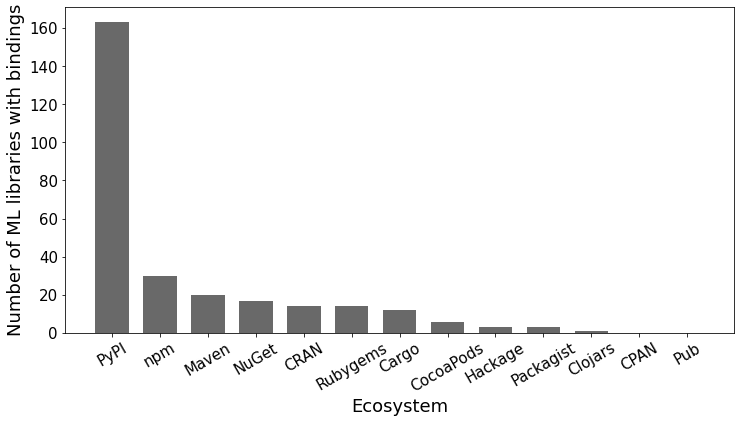

In [18]:
has_official_support = ml_bindings_and_projects.groupby("Host Repo IDs").apply(lambda x: any(x["is official"] != "community") or any(x["Type"] == "Project"))
helper.printValueCountsPercentage(has_official_support)

has_official_support_rids = has_official_support[has_official_support].index
has_official_bindings = ml_bindings_and_projects[ml_bindings_and_projects["Host Repo IDs"].isin(has_official_support_rids)]


figure = plotPlatforms(has_official_bindings[~(has_official_bindings["is official"] == "community")])
# helper.savefig(figure, "RQ2_ML_Bindings_In_Ecos")

# One ecosystem libs

In [19]:
host_rid_g = ml_bindings_and_projects.groupby("Host Repo IDs").apply(lambda x: len(x["Platform"].unique()))
single_eco_ml_rids = host_rid_g[host_rid_g==1].index
single_eco_bindings = ml_bindings_and_projects[ml_bindings_and_projects["Host Repo IDs"].isin(single_eco_ml_rids)]

helper.printValueCountsPercentage(single_eco_bindings.groupby("Host Repo IDs").apply(lambda x: len(x["Platform"].unique())))

has_official_package = single_eco_bindings.groupby("Host Repo IDs").apply(lambda x: any(x["Type"] == "Project"))
has_official_binding = single_eco_bindings.groupby("Host Repo IDs").apply(lambda x: any(x["is official"] != "community"))
has_community_binding = single_eco_bindings.groupby("Host Repo IDs").apply(lambda x: any(x["is official"] == "community"))

print(sum(has_official_package), sum(has_official_binding))
has_official_support = np.logical_or(has_official_package, has_official_binding)
print("has_official_support:")
helper.printValueCountsPercentage(has_official_support)
print(sum(np.logical_and(has_official_package, has_official_binding)))

only_community_binding = np.logical_and(~has_official_support, has_community_binding)
print("only_community_binding")
helper.printValueCountsPercentage(only_community_binding)
# helper.printValueCountsPercentage(single_eco_bindings["Type"])
# single_eco_bindings.groupby("Host Repo IDs").apply(lambda x: )

244 / 244 = 100.0% 1
46 70
has_official_support:
174 / 244 = 71.31147540983606% False
70 / 244 = 28.688524590163933% True
46
only_community_binding
174 / 244 = 71.31147540983606% True
70 / 244 = 28.688524590163933% False


/tmp/ipykernel_363997/1253223219.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  host_rid_g = ml_bindings_and_projects.groupby("Host Repo IDs").apply(lambda x: len(x["Platform"].unique()))
/tmp/ipykernel_363997/1253223219.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  helper.printValueCountsPercentage(single_eco_bindings.groupby("Host Repo IDs").apply(lambda x: len(x["Platform"].unique())))
/tmp/ip